In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc

sc.settings.n_jobs = 24

In [2]:
def shuffle(df):
    '''Shuffle a dataframe column-by-column.
    This ends up being a fast implementation of shuffling each column of a dataframe.
    Copied this function from Meng.
    '''
    index = df.index.values.tolist()
    index = index.copy()
    columns = df.columns.values.tolist()
    for i in columns:
        np.random.shuffle(index)
        temp = df.iloc[:,i].reindex(index).copy()
        temp.reset_index(drop=True,inplace=True)
        if i == 0:
            holding = (temp.values.copy(),)
        else:
            holding = holding+(temp.values.copy(),)
    holding = np.vstack(holding).transpose()
    holding = sc.AnnData(holding)
    return holding

def calculate_PC_variance_of_random_data(adata):
    '''Calculate the most significant PC variance of the adata with
    randomly shuffled columns.
    Adapted from Meng's code.
    '''
    # Repeat the random shuffling 10 times
    randomVariance = []
    for i in range(10):
        print(f'\tRandom shuffle trial {i}.')
        shuffled = shuffle(pd.DataFrame(adata.X))
        sc.tl.pca(shuffled,svd_solver = 'arpack')
        randomVariance.append(shuffled.uns['pca']['variance'][0])
    
    # Return the median of the random PC0 variances
    return np.median(randomVariance)

def jaccard_kernel(sparseConnectivites):
    """Compute Jaccard coefficient between nearest-neighbor sets
    :param idx: numpy array of nearest-neighbor indices
    :return (i, j, s): tuple of indices and jaccard coefficients, suitable for constructing COO matrix
    """
    n = sparseConnectivites.shape[0]
    s = list()
    r = list()
    j = list()
    for i in range(n):
        shared_neighbors = np.fromiter((len(set(sparseConnectivites[i].indices).intersection(set(sparseConnectivites[j].indices))) for j in sparseConnectivites[i].indices),dtype = float)
        num_neighbors = np.fromiter((len(set(sparseConnectivites[i].indices))+len((set(sparseConnectivites[j].indices))) for j in sparseConnectivites[i].indices),dtype = float)
        s.extend(shared_neighbors / (num_neighbors - shared_neighbors))
        r.extend([i]*len(sparseConnectivites[i].indices))
        j.extend(sparseConnectivites[i].indices)
    return r, j, s

def neighbor_graph(kernel,connectivities, directed = False, prune = False):
    r,j,s = kernel(connectivities)
    graph = sp.coo_matrix((s, (r, j)),shape = (connectivities.shape[0],connectivities.shape[0]))

    if not directed:
        if not prune:
            # symmetrize graph by averaging with transpose
            sg = (graph + graph.transpose()).multiply(.5)
        else:
            # symmetrize graph by multiplying with transpose
            sg = graph.multiply(graph2.transpose())
        # retain lower triangle (for efficiency)
        graph = sp.tril(sg, -1)

    return graph.tocsr()


def embed_umap(original_adata, n_pcs=50, n_neighbors=15, metric='euclidean',
              use_jaccard_kernel=False, min_dist=0.5, spread=1):
    '''Embed an adata using UMAP.
    Return a copy of the embeded adata.
    '''
    adata = original_adata.copy()
    
    # Principal component analysis
    if n_pcs == 'auto':
        print('Determine the number of PCs to use by random shuffling.')
        PC_var_threshold = calculate_PC_variance_of_random_data(adata)
        sc.tl.pca(adata, svd_solver='arpack', n_comps=200)
        n_pcs = len(adata.uns['pca']['variance'][adata.uns['pca']['variance'] > PC_var_threshold])
        print(f'Use {n_pcs} PCs.')
    else:
        sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
    
    # Computing the neighborhood graph
    sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, metric=metric)
    if use_jaccard_kernel:
        adata.obsp['connectivities'] = neighbor_graph(jaccard_kernel,
                adata.obsp['connectivities'])

    # Embed with UMAP
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    
    return adata

def clustering(original_adata, n_pcs=50, n_neighbors=15, metric='euclidean',
              use_jaccard_kernel=False, resolution=1, method='leiden'):
    '''Clustering the adata.
    Return a copy of the clustered adata.
    '''
    adata = original_adata.copy()
    
    # Principal component analysis
    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
    
    # Computing the neighborhood graph
    sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors, metric=metric)
    if use_jaccard_kernel:
        adata.obsp['connectivities'] = neighbor_graph(jaccard_kernel,
                adata.obsp['connectivities'])
        
    # Cluster
    if method == 'louvain':
        sc.tl.louvain(adata, resolution=resolution, use_weights=True)
    else:
        # Run leiden as default
        sc.tl.leiden(adata, resolution=resolution, use_weights=True)
    
    return adata

In [3]:
# Read the data
adata = sc.read_h5ad('/home/xingjie/ResearchProjects/cortical_development/published_sc_seq/Bella2021/adata.h5ad')
adata = adata[adata.obs['biosample_id'] == 'E17']

Trying to set attribute `.uns` of view, copying.


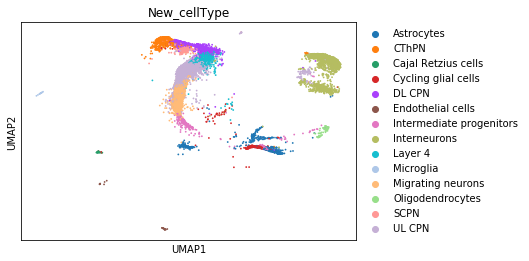

CPU times: user 236 ms, sys: 129 ms, total: 365 ms
Wall time: 227 ms


In [4]:
%%time
# Plot the published UMAP
sc.pl.umap(adata, color='New_cellType')

In [5]:
#Preprocess the data
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


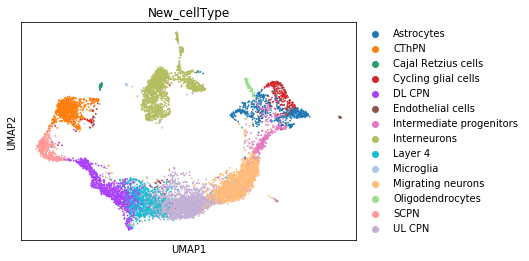

In [6]:
# Plot the published clusters on UMAP for the subset of the data
adata = embed_umap(adata, n_pcs=54)
sc.pl.umap(adata, color='New_cellType')

Use 10 PCs:


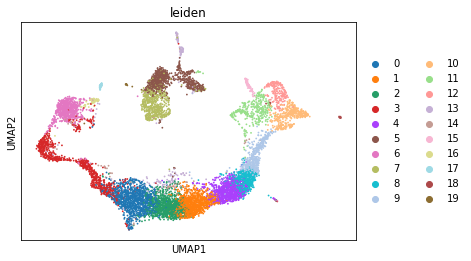

Use 25 PCs:


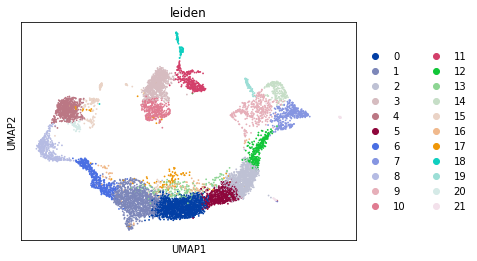

Use 54 PCs:


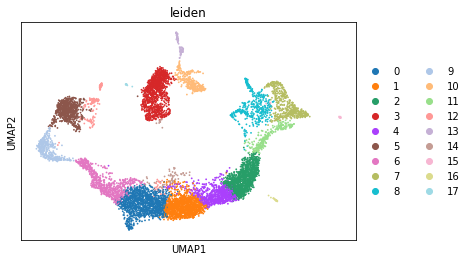

Use 100 PCs:


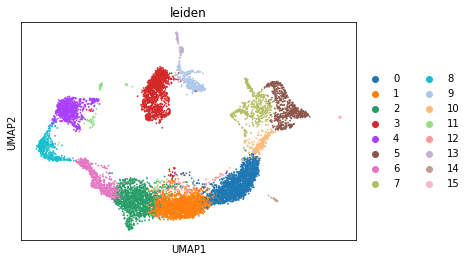

Use 200 PCs:


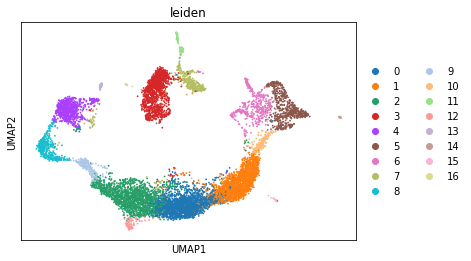

CPU times: user 3min 19s, sys: 5min 14s, total: 8min 34s
Wall time: 18 s


In [7]:
%%time
# Test the effect of the number of PCs
# The number of PCs doesn't seem to have a big impact on the clustering results.
for n_pcs in [10, 25, 54, 100, 200]:
    print(f'Use {n_pcs} PCs:')
    sc.pl.umap(clustering(adata, n_pcs=n_pcs), color='leiden')

Use 5 neighbors:


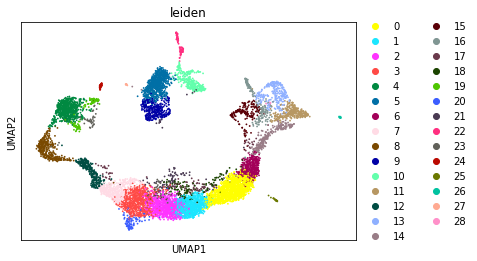

Use 10 neighbors:


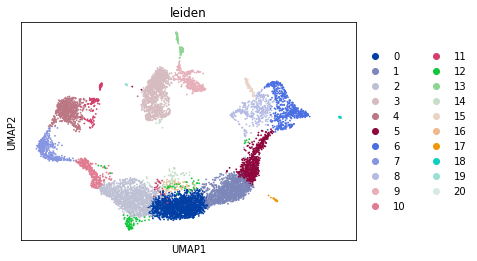

Use 15 neighbors:


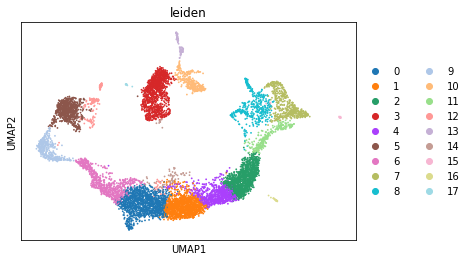

Use 25 neighbors:


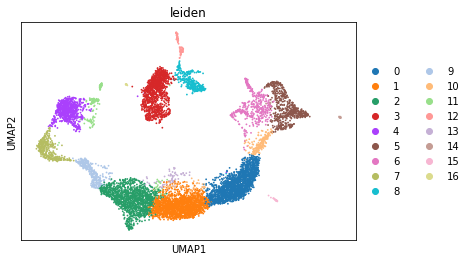

Use 50 neighbors:


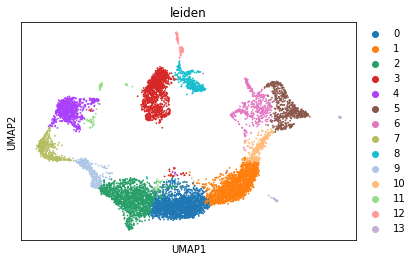

Use 100 neighbors:


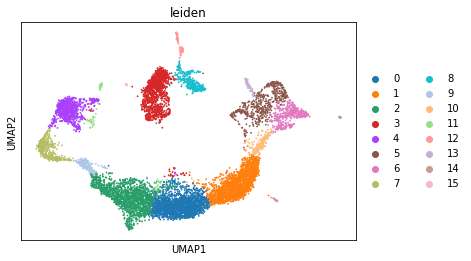

CPU times: user 3min 53s, sys: 4min 2s, total: 7min 56s
Wall time: 26.2 s


In [8]:
%%time
# Test the effect of the number of neighbors
# Small n_neighors result in more clusters.
for n_neighbors in [5, 10, 15, 25, 50, 100]:
    print(f'Use {n_neighbors} neighbors:')
    sc.pl.umap(clustering(adata, n_pcs=54, n_neighbors=n_neighbors), color='leiden')

Without the Jaccard kernel


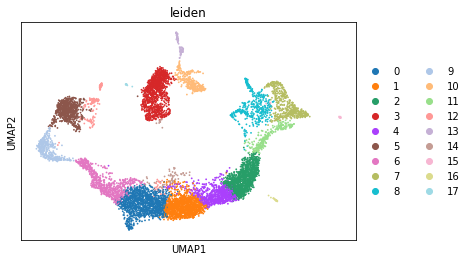

With the Jaccard kernel


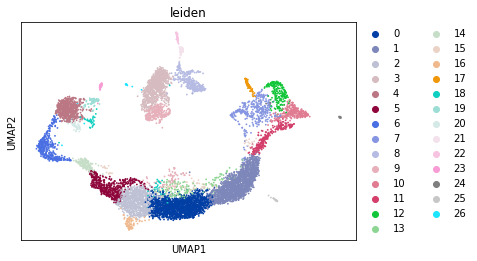

In [9]:
# Test the Jaccard kernel
# The Jaccard kernel seems to help detecting fine structures of the data.
print('Without the Jaccard kernel')
sc.pl.umap(clustering(adata, n_pcs=54, use_jaccard_kernel=False), color='leiden')
print('With the Jaccard kernel')
sc.pl.umap(clustering(adata, n_pcs=54, use_jaccard_kernel=True), color='leiden')

Use cosine metric:


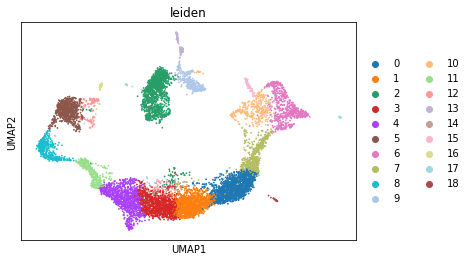

Use euclidean metric:


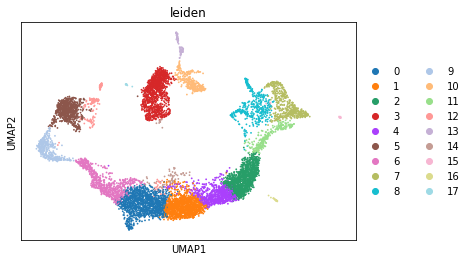

Use manhattan metric:


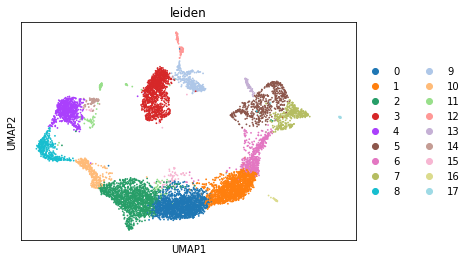

Use correlation metric:


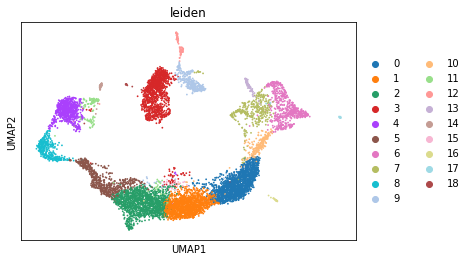

Use hamming metric:


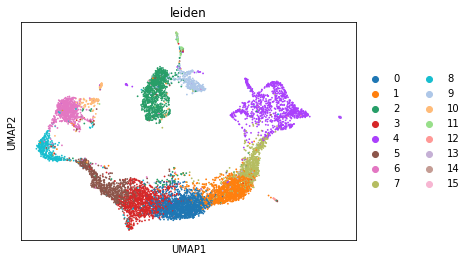

Use jaccard metric:


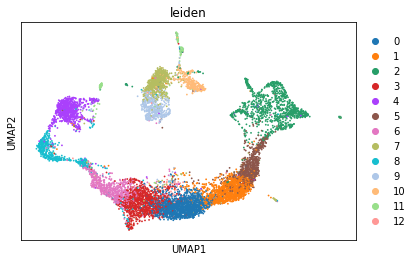

In [10]:
# Test the effect of the distance metrics
for metric in ['cosine', 'euclidean','manhattan', 'correlation', 'hamming', 'jaccard']:
    print(f'Use {metric} metric:')
    sc.pl.umap(clustering(adata, n_pcs=54, metric=metric), color='leiden')

Resolution = 0.1:


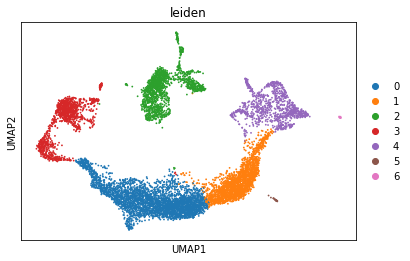

Resolution = 0.5:


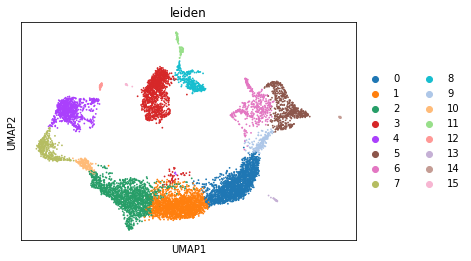

Resolution = 1:


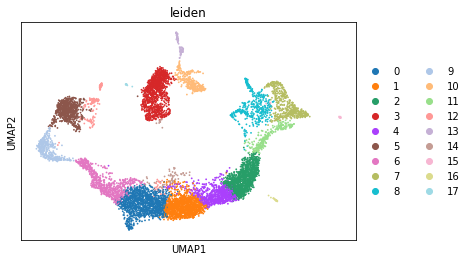

Resolution = 2:


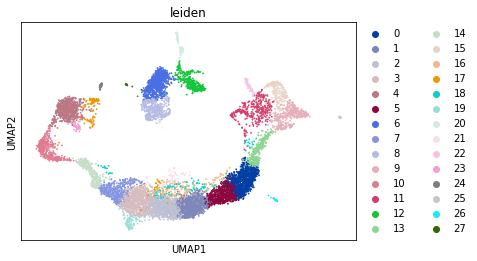

Resolution = 5:


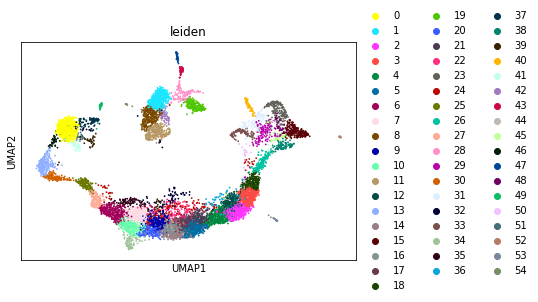

CPU times: user 2min 37s, sys: 4min 16s, total: 6min 54s
Wall time: 16.4 s


In [11]:
%%time
# Test the effect of resolution
for resolution in [0.1, 0.5, 1, 2, 5]:
    print(f'Resolution = {resolution}:')
    sc.pl.umap(clustering(adata, n_pcs=54, resolution=resolution), color='leiden')

Use the leiden method:


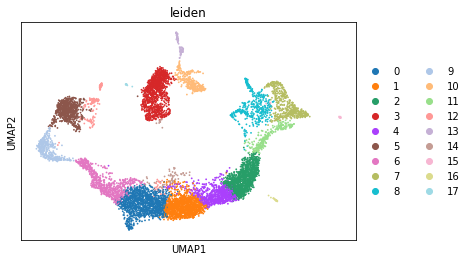

Use the louvain method:


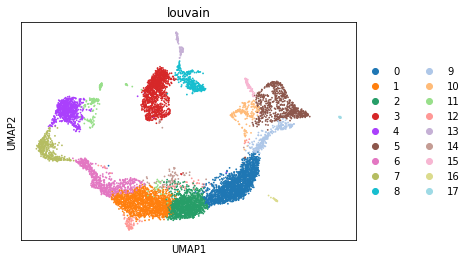

CPU times: user 56.1 s, sys: 1min 23s, total: 2min 20s
Wall time: 5.61 s


In [12]:
%%time
# Test the effect of different methods
for method in ['leiden', 'louvain']:
    print(f'Use the {method} method:')
    sc.pl.umap(clustering(adata, n_pcs=54, method=method), color=method)